# Preprocessing and Training Data Environment
In this notebook the data set is prepared for the modeling step. This includes creating dummie features for categorical data based on strings and adding new features based on the given data set.

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
%matplotlib inline
os.getcwd()

'/Users/lisahw/Documents/Courses and Conferences/DataScience/MyProject/Capstone_02/Springboard/notebooks'

### Load the EDA data set

In [2]:
df = pd.read_csv('../data/interim/COVID_cluster.csv',index_col=0)
df.head()

,Country,Confirmed,Deaths,Recovered,Active,Cardio Death Rate,Diabetes Percentage,Obesity,Undernourished,PopMale,PopFemale,PopTotal,Total Population,Clusters
0,US,0.397961,0.023945,0.000000,0.374016,0.151089,10.79,37.3,1.0,2.812048,3.923944,6.735992,329064.917,2
1,Canada,0.184218,0.012892,0.000000,0.171326,0.105599,7.37,31.3,1.0,3.159014,4.289525,7.448540,37411.038,2
2,United Kingdom,0.320635,0.046886,0.001482,0.272266,0.122137,4.28,29.5,1.0,3.676556,4.856698,8.533254,67530.161,2
3,China,0.005858,0.000323,0.005519,0.000016,0.261899,9.74,6.6,8.5,1.555179,2.048110,3.603289,1433783.692,0
4,Netherlands,0.249054,0.031824,0.000871,0.216358,0.109361,5.29,23.1,1.0,3.546222,4.785875,8.332098,17097.123,2


In [18]:
df.drop(['Recovered','Active','Clusters'],axis=1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Confirmed,147.0,0.073584,0.118237,0.000117,0.003848,0.016204,0.101505,6.296591e-01
Deaths,147.0,0.004182,0.011031,0.000000,0.000105,0.000417,0.002382,7.436310e-02
Cardio Death Rate,147.0,0.256981,0.119594,0.079370,0.162807,0.243811,0.324205,7.244167e-01
Diabetes Percentage,147.0,7.303469,3.760702,0.990000,4.800000,6.930000,9.030000,2.202000e+01
Obesity,147.0,18.534694,9.416538,2.100000,8.200000,21.900000,25.700000,3.730000e+01
Undernourished,147.0,10.653061,12.095308,1.000000,1.000000,6.500000,14.600000,5.960000e+01
PopMale,147.0,1.552883,1.258690,0.185446,0.461343,1.098134,2.546442,5.512896e+00
PopFemale,147.0,2.386105,2.062953,0.095829,0.663079,1.577732,3.994760,8.528817e+00
PopTotal,147.0,3.938988,3.281700,0.301110,1.126508,2.678089,6.688357,1.404171e+01
Total Population,147.0,49803.233163,167285.832961,110.593000,4226.758500,11263.079000,35370.147500,1.433784e+06


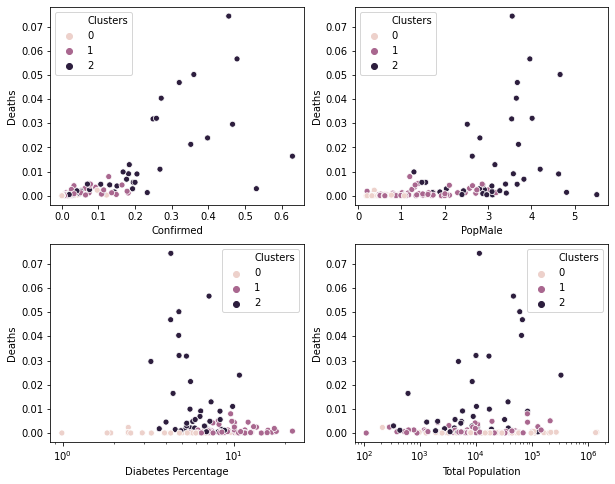

In [43]:
fig = plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
grid = sns.scatterplot(x='Confirmed',y='Deaths',hue='Clusters',data=df)
# grid.set(xscale='log')
plt.subplot(2,2,2)
grid = sns.scatterplot(x='PopMale',y='Deaths',hue='Clusters',data=df)
# grid.set(xscale='log')
plt.subplot(2,2,3)
grid = sns.scatterplot(x='Diabetes Percentage',y='Deaths',hue='Clusters',data=df)
grid.set(xscale='log')
plt.subplot(2,2,4)
grid = sns.scatterplot(x='Total Population',y='Deaths',hue='Clusters',data=df)
grid.set(xscale='log')
plt.show()
fig.savefig('../reports/figures/Scatter_Top4.png')

The cluster assignment is categorical data, while the country is rather an identifier. An interesting property is the Total Population (in thousands) since all other measures are relative to it for absolute numbers.

### Create dummies for the Clusters

In [3]:
df_test = pd.get_dummies(df['Clusters'],drop_first=True,prefix='Cluster')
df_all = pd.concat([df.drop('Clusters',axis=1),df_test],axis=1,join='inner')
df_all.head()

,Country,Confirmed,Deaths,Recovered,Active,Cardio Death Rate,Diabetes Percentage,Obesity,Undernourished,PopMale,PopFemale,PopTotal,Total Population,Cluster_1,Cluster_2
0,US,0.397961,0.023945,0.000000,0.374016,0.151089,10.79,37.3,1.0,2.812048,3.923944,6.735992,329064.917,0,1
1,Canada,0.184218,0.012892,0.000000,0.171326,0.105599,7.37,31.3,1.0,3.159014,4.289525,7.448540,37411.038,0,1
2,United Kingdom,0.320635,0.046886,0.001482,0.272266,0.122137,4.28,29.5,1.0,3.676556,4.856698,8.533254,67530.161,0,1
3,China,0.005858,0.000323,0.005519,0.000016,0.261899,9.74,6.6,8.5,1.555179,2.048110,3.603289,1433783.692,0,0
4,Netherlands,0.249054,0.031824,0.000871,0.216358,0.109361,5.29,23.1,1.0,3.546222,4.785875,8.332098,17097.123,0,1


### Add new feature: COVID Death Rate relative to confirmed cases

In [4]:
df_all['covid_fatal'] = df_all['Deaths']/df_all['Confirmed']

In [5]:
df_all.head()

,Country,Confirmed,Deaths,Recovered,Active,Cardio Death Rate,Diabetes Percentage,Obesity,Undernourished,PopMale,PopFemale,PopTotal,Total Population,Cluster_1,Cluster_2,covid_fatal
0,US,0.397961,0.023945,0.000000,0.374016,0.151089,10.79,37.3,1.0,2.812048,3.923944,6.735992,329064.917,0,1,0.060170
1,Canada,0.184218,0.012892,0.000000,0.171326,0.105599,7.37,31.3,1.0,3.159014,4.289525,7.448540,37411.038,0,1,0.069982
2,United Kingdom,0.320635,0.046886,0.001482,0.272266,0.122137,4.28,29.5,1.0,3.676556,4.856698,8.533254,67530.161,0,1,0.146228
3,China,0.005858,0.000323,0.005519,0.000016,0.261899,9.74,6.6,8.5,1.555179,2.048110,3.603289,1433783.692,0,0,0.055209
4,Netherlands,0.249054,0.031824,0.000871,0.216358,0.109361,5.29,23.1,1.0,3.546222,4.785875,8.332098,17097.123,0,1,0.127780


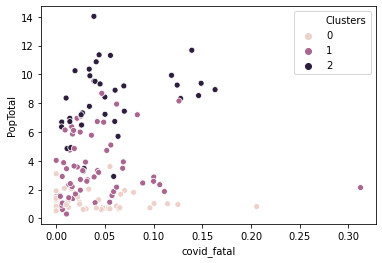

In [18]:
sns.scatterplot(df_all['covid_fatal'],df_all['PopTotal'],df['Clusters'])

### Standardize value ranges
The StandardScaler function is used to standardize all value ranges except for the 2 dummy features.

In [5]:
from sklearn.preprocessing import StandardScaler
df_temp = df_all.drop(['Country','Cluster_1','Cluster_2'],axis=1)
scaler = StandardScaler()
scaler.fit(df_temp.values)
# print(scaler.mean_)
df_scaled = pd.DataFrame(scaler.transform(df_temp.values),columns=df_temp.columns)
df_scaled = pd.concat([df_all['Country'],df_scaled,df_all.loc[:,['Cluster_1','Cluster_2']]],axis=1,join='inner')
del df_temp
df_scaled.head()


,Country,Confirmed,Deaths,Recovered,Active,Cardio Death Rate,Diabetes Percentage,Obesity,Undernourished,PopMale,PopFemale,PopTotal,Total Population,covid_fatal,Cluster_1,Cluster_2
0,US,2.752835,1.797774,-0.422845,5.481596,-0.888446,0.930265,1.999616,-0.800812,1.003797,0.748004,0.855217,1.675076,0.381915,0,1
1,Canada,0.938900,0.792328,-0.422845,2.205108,-1.270117,0.017751,1.360261,-0.800812,1.280396,0.925822,1.073087,-0.074331,0.601958,0,1
2,United Kingdom,2.096601,3.884546,-0.404671,3.836811,-1.131361,-0.806713,1.168454,-0.800812,1.692977,1.201695,1.404751,0.106330,2.311817,0,1
3,China,-0.574762,-0.350955,-0.355182,-0.564141,0.041266,0.650108,-1.271752,-0.178617,0.001830,-0.164400,-0.102644,8.301432,0.270671,0,0
4,Netherlands,1.489127,2.514475,-0.412160,2.933047,-1.238552,-0.537228,0.486475,-0.800812,1.589076,1.167247,1.343245,-0.196179,1.898113,0,1


In [40]:
df_scaled.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Confirmed,147.0,-3.247591e-17,1.003419,-0.623486,-0.591817,-0.486957,0.236951,4.719149
Deaths,147.0,-4.720336e-17,1.003419,-0.380374,-0.370784,-0.342408,-0.163702,6.384002
Recovered,147.0,-2.076948e-17,1.003419,-0.422845,-0.408573,-0.355836,-0.067954,6.646002
Active,147.0,1.812609e-17,1.003419,-0.564396,-0.540252,-0.443827,-0.044857,5.481596
Cardio Death Rate,147.0,-6.117555e-17,1.003419,-1.490183,-0.790136,-0.110500,0.564020,3.921871
Diabetes Percentage,147.0,-3.413747e-16,1.003419,-1.684540,-0.667968,-0.099648,0.460668,3.926619
Obesity,147.0,3.088988e-16,1.003419,-1.751268,-1.101257,0.358604,0.763529,1.999616
Undernourished,147.0,-6.948335e-17,1.003419,-0.800812,-0.800812,-0.344535,0.327435,4.060606
PopMale,147.0,0.000000e+00,1.003419,-1.090112,-0.870169,-0.362523,0.792058,3.156894
PopFemale,147.0,-1.042250e-16,1.003419,-1.113988,-0.838078,-0.393192,0.782449,2.987810


As expected, the mean for the scaled values is zero and the standard deviation is one.

### Verify, that the clustering is appropiate for the scaled data set.

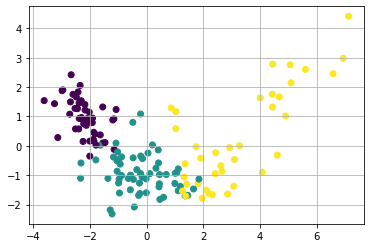

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df_scaled.drop(['Country','Cluster_1','Cluster_2'],axis=1).values)
plt.figure()
plt.scatter(pca_features[:,0],pca_features[:,1],c = df.Clusters)
plt.grid()
plt.show()

### Train-Test-Split
Our total data set consists of 147 instances and 14 features. To allow sufficient instances per set, 75% goes to training and 25% to testing. As we have seen before, some data is covariant and some features should be dropped since they do not add extra information.

In [30]:
# Drop covariant features
df_analysis = df_scaled.drop(['Country','Recovered','Active','PopFemale','PopTotal'],axis=1)

In [31]:
# We want to predict the death rate for a certain country
X = df_analysis.drop(['Deaths'],axis=1)
y = df_analysis['Deaths']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)


In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 145 to 102
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            110 non-null    float64
 1   Cardio Death Rate    110 non-null    float64
 2   Diabetes Percentage  110 non-null    float64
 3   Obesity              110 non-null    float64
 4   Undernourished       110 non-null    float64
 5   PopMale              110 non-null    float64
 6   Total Population     110 non-null    float64
 7   Cluster_1            110 non-null    uint8  
 8   Cluster_2            110 non-null    uint8  
dtypes: float64(7), uint8(2)
memory usage: 7.1 KB


Now we have a training and testing data set to model and predict the death rate for a certain country based on the health conditions of the nation. Our initial question was whether we can predict the number of COVID-19 cases based on the health conditions and demography of a country. This will be assessed in a second step.

In [32]:
import sqlite3

with sqlite3.connect('../data/interim/COVID_Deaths_train_test.db') as conn:
#     cur = conn.cursor()
#     cur.execute('CREATE TABLE XTRAIN'+descr)
#     conn.commit()
    # Add train and test data
    X_train.to_sql('XTRAIN',conn,if_exists='replace')
    X_test.to_sql('XTEST',conn,if_exists='replace')
    y_train.to_sql('yTRAIN',conn,if_exists='replace')
    y_test.to_sql('yTEST',conn,if_exists='replace')

/Users/lisahw/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2663: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


### Create another test train data set for the death rate

In [35]:
# We want to predict the death rate for a certain country
X = df_analysis.drop(['covid_fatal','Confirmed','Deaths'],axis=1)
y = df_analysis['covid_fatal']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)


In [36]:
import sqlite3

with sqlite3.connect('../data/interim/COVID_fatal_train_test.db') as conn:
#     cur = conn.cursor()
#     cur.execute('CREATE TABLE XTRAIN'+descr)
#     conn.commit()
    # Add train and test data
    X_train.to_sql('XTRAIN',conn,if_exists='replace')
    X_test.to_sql('XTEST',conn,if_exists='replace')
    y_train.to_sql('yTRAIN',conn,if_exists='replace')
    y_test.to_sql('yTEST',conn,if_exists='replace')